# SARIMA Model - Total Immigration 1820 - 2017

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

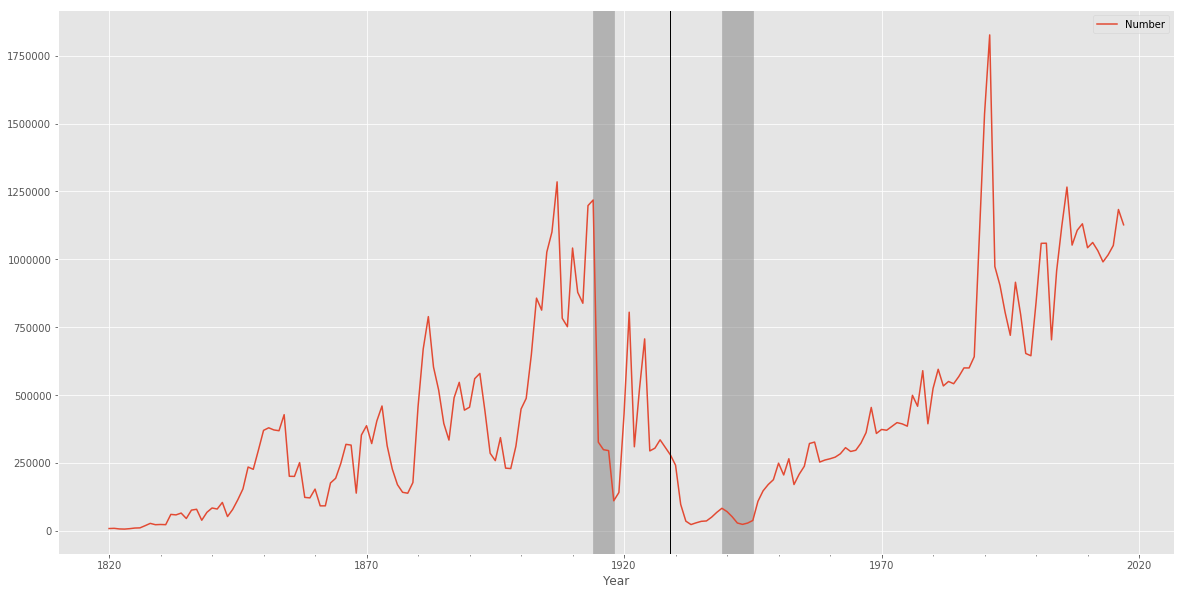

In [2]:
by_year_df = pd.read_excel('Data/Total_immigration_by_year.xlsx') 
by_year_df.set_index('Year', inplace = True) #set index as year
by_year_df.index= by_year_df.index.astype(str) #change to str for date time format
by_year_df.index = pd.to_datetime(by_year_df.index)#, format='%d/%m/%y') #convert index to correct date time for future slicing
total_immigration = by_year_df['1820-01-01':]
total_immigration.plot(figsize = (20,10))
plt.axvline(pd.to_datetime('1929-10-29'), color='black', linestyle='-', lw=1)

plt.axvspan(pd.to_datetime('1939-09-01'), pd.to_datetime('1945-09-01'), alpha=0.5, color='grey')
plt.axvspan(pd.to_datetime('1914-07-28'), pd.to_datetime('1918-11-11'), alpha=0.5, color='grey')

# Terms:

`p`= allows us to incorporate the effect of past values into our model. This would be similar to stating that immigration in this year will be similar to the past couple of years

`d` = the number of differences ; identifies the number of lag values to subtract from the current observation. This would be similar to stating that immigration in this year will be similar to the past couple of years if the difference in amount of immigration in the last *n* years is small. 

`q` = Number of MA (Moving Average) terms; sets the error of the model as a linear combination of the error values observed at previous time points in the past

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

In [3]:
# Define the p, d and q parameters to take any value between 0 and 5 
# p = d = q = range(0, 5)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


## AIC (Akaike Information Criterion) 

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using `statsmodels` library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

1. Initialize an empty list to store results
2. iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
3. Run `SARIMAX` from statsmodels for each iteration. Details can be found [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Set `enforce_stationarity` and `enforce_invertibility` to False. 
4. Get the results in each iteration with `model.fit()` and store the AIC values. 
5. Find the lowest AIC and select parameters for further analysis. 

NOTE: 
* Integrate exception handling with `continue`. 
* An overview of Akaike Information Criterion can be viewed [HERE](http://www.statisticshowto.com/akaikes-information-criterion/)



In [4]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
#- ER ran overnight 1.22.19, 
#best parameters look to be (0,4,3) X (3,4,4,12) - AIC 3059
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(total_immigration,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

            

In [5]:
# Find the parameters with minimal AIC value.

# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]


#best parameters look to be (0,4,3) X (3,4,4,12) - AIC 3059
# previously, best model based on range 0,2: 
#     pdq         (0, 1, 0)
# pdqs    (1, 1, 1, 12)
# aic           4631.75

## Model Fitting

Above, we identified the set of parameters that produced the best fitting model to our time series data

In [6]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(total_immigration,
                                order=(0,4,3),
                                seasonal_order=(3,4,4,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# previous best results:
#     ==============================================================================
#                  coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ar.S.L12      -0.2522      0.113     -2.232      0.026      -0.474      -0.031
# ma.S.L12      -0.9985      0.080    -12.552      0.000      -1.154      -0.843
# sigma2      4.055e+10   1.86e-12   2.18e+22      0.000    4.06e+10    4.06e+10
# ==============================================================================

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.3245      1.221     -1.903      0.057      -4.718       0.069
ma.L2          2.2488      1.959      1.148      0.251      -1.591       6.088
ma.L3         -0.9284      0.991     -0.936      0.349      -2.871       1.015
ar.S.L12      -2.6441    241.765     -0.011      0.991    -476.494     471.206
ar.S.L24      -0.5545    739.747     -0.001      0.999   -1450.431    1449.322
ar.S.L36       0.8087    446.220      0.002      0.999    -873.767     875.384
ma.S.L12      -0.5485    242.291     -0.002      0.998    -475.430     474.333
ma.S.L24      -0.0154     31.847     -0.000      1.000     -62.435      62.404
ma.S.L36      -0.0555     16.311     -0.003      0.997     -32.024      31.913
ma.S.L48       0.0144     22.996      0.001      1.000     -45.057      45.085
sigma2      1.653e+13   2.99e-08   5.53e+20      0.0

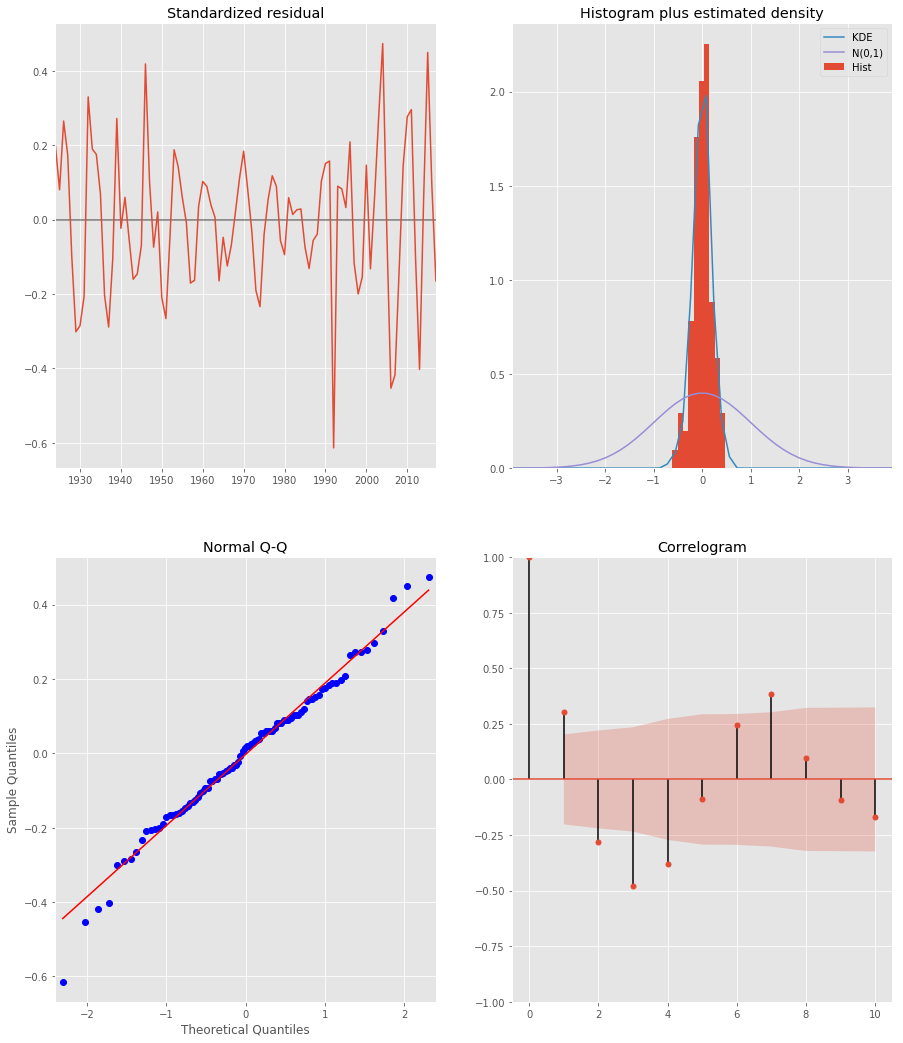

In [7]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the Model

### One-step Ahead Forecasting

* Get the predictions from 2010 till 2017 ( end of time-series)

* Get the confidence intervals for all predictions.

* For `get_predictions()`, set the `dynamic` parameter to False to ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.



In [8]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_conf = pred.conf_int()

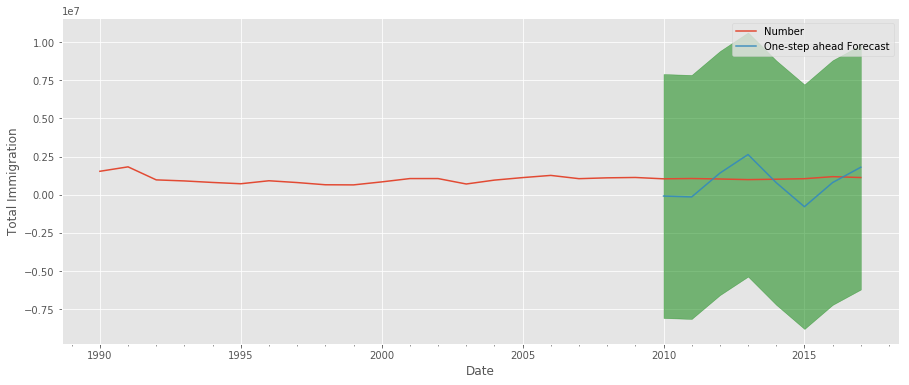

In [9]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = total_immigration['1990':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Total Immigration')
plt.legend()

plt.show()

The forecasts align with the true values  as seen above,with overall increase trend. We shall also check for the accuracy of our forecasts using  **MSE (Mean Squared Error)**. This will provide us with the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [12]:
total_immigration_truth

,Number
Year,
2010-01-01,1042625
2011-01-01,1062040
2012-01-01,1031631
2013-01-01,990553
2014-01-01,1016518
2015-01-01,1051031
2016-01-01,1183505
2017-01-01,1127167


In [10]:
# Get the Real and predicted values
total_immigration_forecasted = pred.predicted_mean
total_immigration_truth = total_immigration['2010-01-01':]

# Compute the mean square error
mse = ((total_immigration_forecasted - total_immigration_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error will provide us with the average error of our forecasts. 
#For each predicted value, we compute its distance to the true value and square the result. 

The Mean Squared Error of our forecasts is 2010-01-01 00:00:00   NaN
2011-01-01 00:00:00   NaN
2012-01-01 00:00:00   NaN
2013-01-01 00:00:00   NaN
2014-01-01 00:00:00   NaN
2015-01-01 00:00:00   NaN
2016-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
Number                NaN
dtype: float64


### Dynamic Forecasting

In [12]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.



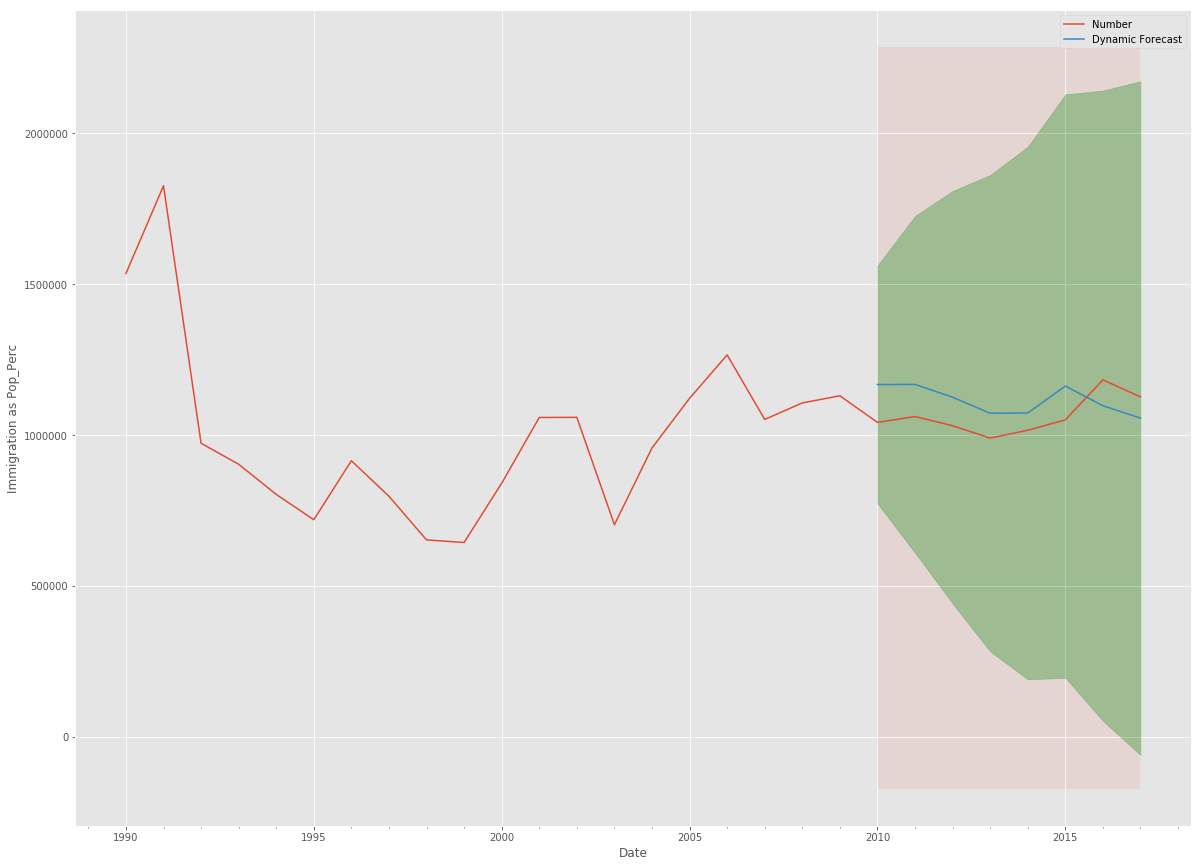

In [13]:
# Plot the dynamic forecast with confidence intervals.

ax = total_immigration['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2010-01-01'), total_immigration_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Total Immigration')

plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the MSE.

In [14]:
# Extract the predicted and true values of our time series
total_immigration_forecasted = pred_dynamic.predicted_mean
total_immigration_truth = total_immigration['2010-01-01':]

# Compute the mean square error
mse = ((total_immigration_forecasted - total_immigration_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 1.01

The Mean Squared Error of our forecasts is 2010-01-01 00:00:00   NaN
2011-01-01 00:00:00   NaN
2012-01-01 00:00:00   NaN
2013-01-01 00:00:00   NaN
2014-01-01 00:00:00   NaN
2015-01-01 00:00:00   NaN
2016-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
Number                NaN
dtype: float64


## Producing and Visualizing Forecasts

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. The `get_forecast()` attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [15]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2263-01-01 00:00:00

We can use the output of this code to plot the time series and forecasts of its future values.



NameError: name 'prediction' is not defined

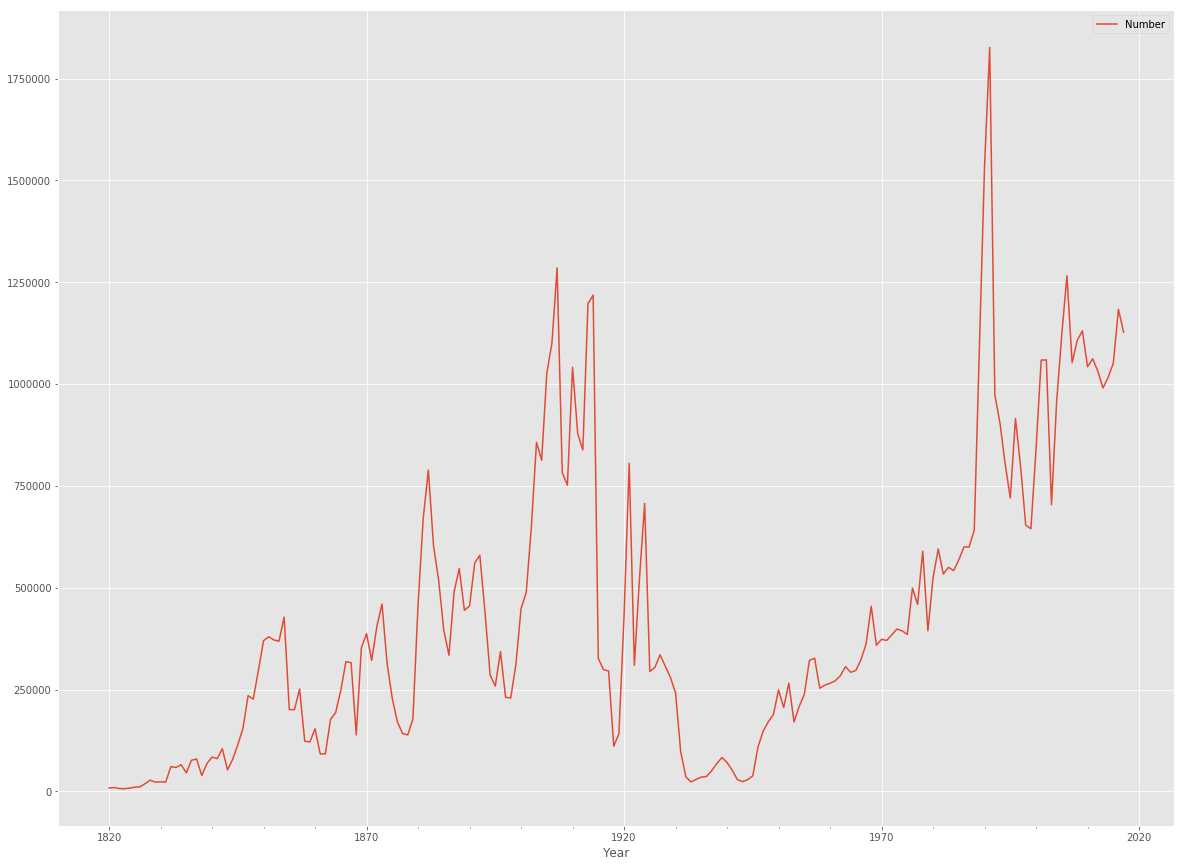

In [16]:
# Plot future predictions with confidence intervals

ax = total_immigration.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()